## Investigate how closely the Zacros A-factor parameterization matches different RMG reaction types

$$A_{fwd}(T)=exp\left[-\left(\alpha_1 \cdot \log(T) + \frac{\alpha_2}{T}+\alpha_3+\alpha_4 \cdot T +\alpha_5 \cdot T^2 + \alpha_6 \cdot T^3 +\alpha_7 \cdot T^4\right) \right]$$

Zacros manual says "log is the natural logarithm"

In [1]:
import rmgpy.chemkin
import rmgpy.constants
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
%matplotlib inline

In [2]:
def A_fwd(T, a1, a2, a3, a4, a5, a6, a7):  # zacros manual says log is the natural log
    return np.exp(-(a1 * np.log(T) + a2 / T + a3 + a4*T + a5 * np.float_power(T, 2.0)+ a6 * np.float_power(T, 3.0) + a7 * np.float_power(T, 4.0)))

In [3]:
def log_A_fwd(T, a1, a2, a3, a4, a5, a6, a7):  # zacros manual says log is the natural log
    return -(a1 * np.log(T) + a2 / T + a3 + a4*T + a5 * np.float_power(T, 2.0)+ a6 * np.float_power(T, 3.0) + a7 * np.float_power(T, 4.0))

In [4]:


def plot_kinetics(rxns, labels=None):
    """Function for plotting reaction kinetics
    Takes in a list of RMG reactions (rmgpy.reaction.Reaction) or a single reaction
    """
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('ln(k)')

    if type(rxns) != list:
        rxns = [rxns]
    
    T = np.linspace(300, 3000, 1001)
    for rxn in rxns:
        k = np.zeros(len(T))
        for i in range(0, len(T)):
            k[i] = rxn.get_rate_coefficient(T[i], 101325)
        plt.plot(1000.0 / T, np.log(k))

    if labels:
        plt.legend(labels)
    plt.show()


In [5]:
# load an example catalysis mechanism from RMG

gas_mech_file = '/home/moon/rmg/rmg2kmc/zacros/rmg_example_model/chem_annotated-gas.inp'
surface_mech_file = '/home/moon/rmg/rmg2kmc/zacros/rmg_example_model/chem_annotated-surface.inp'
dictionary_path = '/home/moon/rmg/rmg2kmc/zacros/rmg_example_model/species_dictionary.txt'


gas_species, gas_reactions = rmgpy.chemkin.load_chemkin_file(
    gas_mech_file,
    dictionary_path=dictionary_path
)
surface_species, surface_reactions = rmgpy.chemkin.load_chemkin_file(
    surface_mech_file,
    dictionary_path=dictionary_path
)


In [6]:
for i in range(0, len(surface_reactions)):
    print(i, surface_reactions[i].kinetics)

0 Arrhenius(A=(3.7e+21,'cm^3/(mol*s)'), n=0, Ea=(66.611,'kcal/mol'), T0=(1,'K'))
1 StickingCoefficient(A=0.008, n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 11 CH4 + X <=> CH4X in Surface_Adsorption_vdW/training
This reaction matched rate rule [Adsorbate;VacantSite]
family: Surface_Adsorption_vdW metal: None""")
2 Arrhenius(A=(3.3e+21,'cm^3/(mol*s)'), n=0, Ea=(11.95,'kcal/mol'), T0=(1,'K'))
3 Arrhenius(A=(1.54e+21,'cm^3/(mol*s)'), n=0.087, Ea=(13.337,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 12 CH4* + X_4 <=> CH3* + H* in Surface_Dissociation_vdW/training
This reaction matched rate rule [C-H;VacantSite]
family: Surface_Dissociation_vdW metal: None""")
4 StickingCoefficient(A=0.85, n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [Adsorbate;VacantSite] for rate rule [CH2-H;VacantSite]
Euclidian distance = 2.0
family: Surface_Adsorption_Single""")
5 Arrhenius(A=(5e+18,'cm^6/(mol^2*s)'), n=0.7, Ea=(10.038,'kcal/mol'), T0=(1,'K'))
6 Arrh

In [7]:
SDEN = 2.72e-9 * 100 * 100 # mol/cm^2 * (100cm/ m)^2

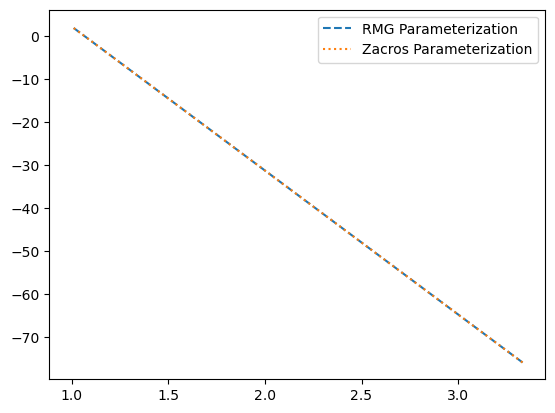

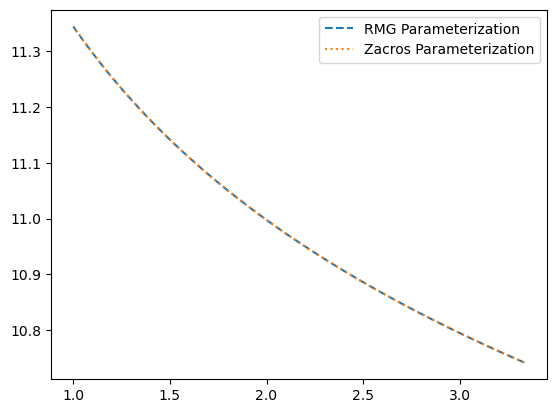

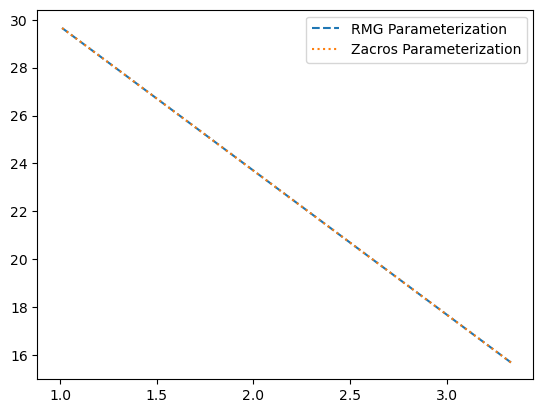

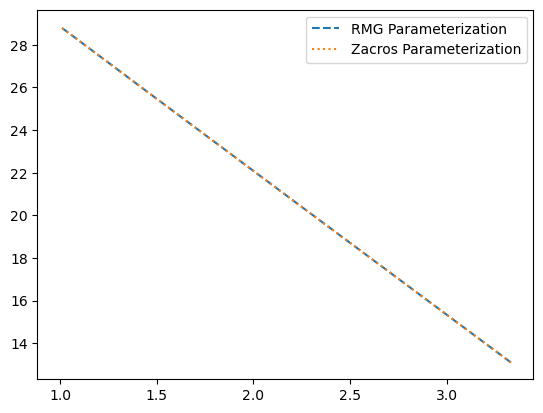

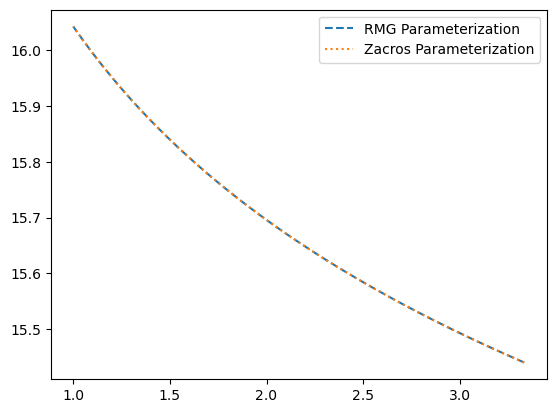

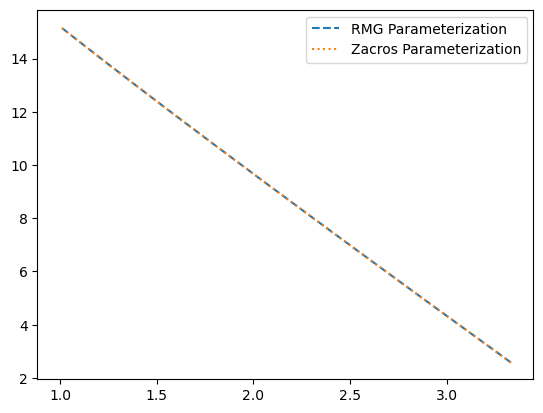

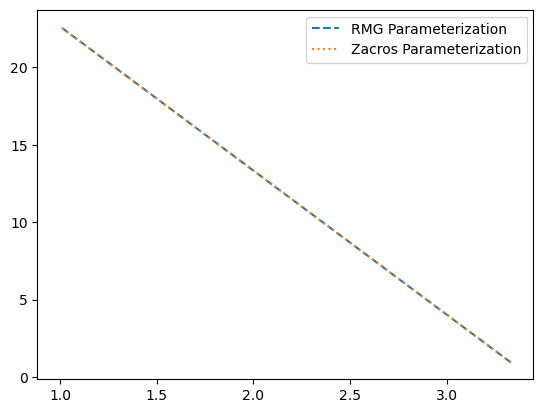

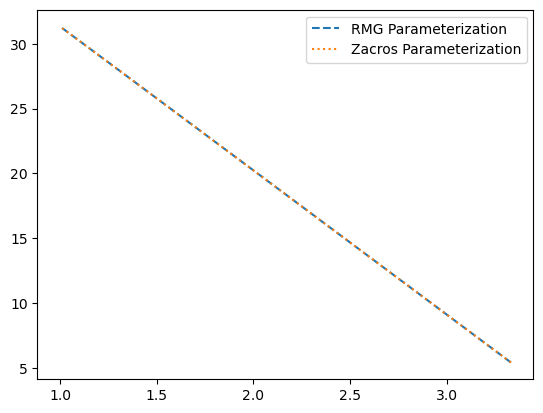

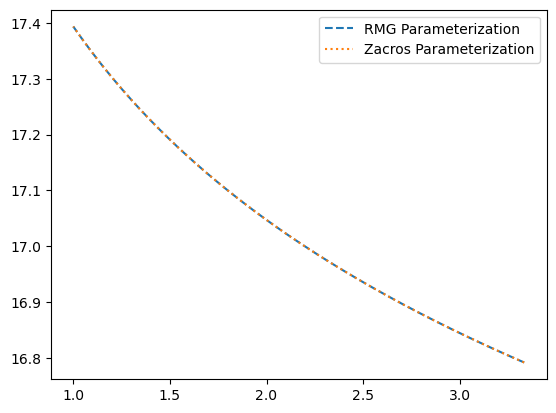

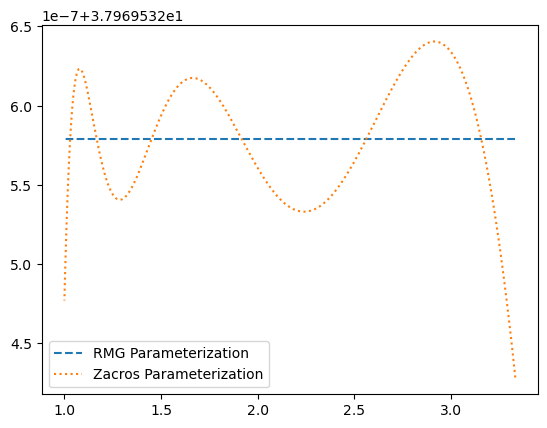

In [8]:
# fit the 7 parameters to the reaction rate

# reaction 28 has a temperature exponent
for rxn_index in range(0, 10):

    temperatures = np.linspace(300, 1000, 1001)
    rates = np.zeros(len(temperatures))
#     A_factors = np.zeros(len(temperatures))
    for i in range(len(temperatures)):
        try:
            rates[i] = surface_reactions[rxn_index].kinetics.get_rate_coefficient(temperatures[i])
        except NotImplementedError:
            rates[i] = surface_reactions[rxn_index].get_rate_coefficient(temperatures[i], surface_site_density=SDEN)

    A_factors = np.divide(
        rates,
        np.exp(
            -surface_reactions[rxn_index].kinetics.Ea.value_si / rmgpy.constants.R / temperatures
        )
    )

#     # choose starting point using polyfit
#     poly_params = np.polyfit(temperatures, np.log(A_factors), 4)
#     p0 = np.zeros(7)
#     p0[2:] = poly_params
    
    
    popt, pcov = scipy.optimize.curve_fit(log_A_fwd, temperatures, np.log(A_factors))
    log_A_est = log_A_fwd(temperatures, *popt)
    rates_est = np.multiply(np.exp(log_A_est), np.exp(
            -surface_reactions[rxn_index].kinetics.Ea.value_si / rmgpy.constants.R / temperatures
        ))

    plt.figure()
    plt.clf()
    plt.plot(1000 / temperatures, np.log(rates), linestyle='dashed', label='RMG Parameterization')
    
    
    plt.plot(1000 / temperatures, np.log(rates_est), linestyle='dotted', label='Zacros Parameterization')
    plt.legend()
#     break

In [9]:
np.sum(np.float_power(np.log(rates_est) - np.log(rates), 2.0))

1.1918863311200105e-12